In [1]:
# general imports
import pandas as pd
import numpy as np

from datetime import datetime ,timedelta
from pandas.tseries.offsets import MonthEnd

# for data read
import pickle
import os

# import warnings
# warnings.filterwarnings(action='ignore')

In [2]:
# Manual Inputs
# We choose dates between 2010 and 2019 as this 10 year period has no major financial global crises
# We intend to use 9 years (2010-2018) for training, and 1 year (2019) for testing

root_dir          = r'C:\Users\wsteynber\_Data Science'
# root_dir          = r'c:\Users\Zoli\Downloads\python\academy'
price_metric      = 'Open'
filt_date_min     = datetime(2010,1,1)
filt_date_max     = datetime(2019,1,1) + MonthEnd(0) + timedelta(days=1)
filt_date_min_ext = filt_date_min - timedelta(days=10) # extra days used for linear interpolation
filt_date_max_ext = filt_date_max + timedelta(days=10) # extra days used for linear interpolation

In [3]:
# Import time series data and filter according to input dates

df_ts_0_raw         = pd.read_pickle(root_dir + r'\50yr_timeSeries_data.pkl')

df_ts_0_raw         = df_ts_0_raw.loc[: ,(slice(None) ,[price_metric])]
df_ts_0_raw.columns = df_ts_0_raw.columns.droplevel(1)

filt                = ((filt_date_min_ext <= df_ts_0_raw.index) & (df_ts_0_raw.index < filt_date_max_ext))
df_ts_0_raw         = df_ts_0_raw.loc[filt]

In [4]:
# We observe no data on weekends and other days (possibly public holidays?)
# ie 2010-01-01 to 2010-01-03 missing
# ie 2010-01-09 to 2010-01-10 missing ... and so on

df_ts_0_raw[:20].index

DatetimeIndex(['2009-12-22', '2009-12-23', '2009-12-24', '2009-12-28',
               '2009-12-29', '2009-12-30', '2009-12-31', '2010-01-04',
               '2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08',
               '2010-01-11', '2010-01-12', '2010-01-13', '2010-01-14',
               '2010-01-15', '2010-01-19', '2010-01-20', '2010-01-21'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [5]:
# Create DataFrame with every day of the week
# Use linear interpolation to populate, where possible, missing values
# Remove dates (indexes) that were just there for linear interpolation purposes

df_all_dates = pd.DataFrame(pd.date_range(filt_date_min_ext ,filt_date_max_ext ,freq='d') ,columns=['Date']).set_index(['Date'])

df_ts_1_lin_inter = pd.concat([df_all_dates ,df_ts_0_raw] ,axis=1)
df_ts_1_lin_inter = df_ts_1_lin_inter.interpolate(limit_direction='forward')

filt              = ((filt_date_min <= df_ts_1_lin_inter.index) & (df_ts_1_lin_inter.index < filt_date_max))
df_ts_1_lin_inter = df_ts_1_lin_inter[filt]

df_ts_1_lin_inter.head(5)

,TRGP,FDS,SYY,RCL,PSA,FISV,HUM,SNA,EMR,CAT,...,INTC,KDP,ADP,WMB,CCL,ATVI,DLTR,DLR,FE,ODFL
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,NaN,66.532499,28.327501,25.622500,82.622503,12.270625,44.475001,42.897501,43.187501,57.612499,...,20.647501,28.740000,38.219930,17.453432,32.192500,11.32,16.184166,50.110001,47.227500,9.162963
2010-01-02,NaN,66.424999,28.285001,25.795000,82.335003,12.266250,44.460001,42.845001,43.175001,57.625000,...,20.695001,28.670000,38.222124,17.461584,32.225000,11.29,16.181666,50.200001,47.025000,9.140741
2010-01-03,NaN,66.317499,28.242501,25.967500,82.047503,12.261875,44.445001,42.792501,43.162501,57.637501,...,20.742501,28.600000,38.224319,17.469736,32.257501,11.26,16.179166,50.290001,46.822499,9.118519
2010-01-04,NaN,66.209999,28.200001,26.139999,81.760002,12.257500,44.430000,42.740002,43.150002,57.650002,...,20.790001,28.530001,38.226513,17.477888,32.290001,11.23,16.176666,50.380001,46.619999,9.096296
2010-01-05,NaN,66.750000,28.010000,26.110001,79.870003,12.312500,45.790001,42.630001,43.380001,58.549999,...,20.940001,28.959999,37.445126,17.534952,32.279999,11.24,16.013332,50.029999,46.650002,8.642963


Text(0.5, 1.0, 'Distribution of NaN values by Stock')

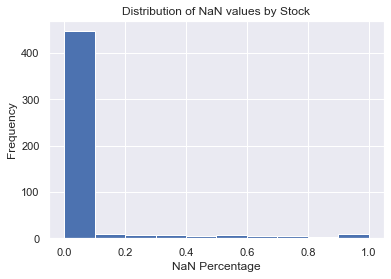

In [6]:
# Check NaN values in time series data
# We observe that after linear interpolation only an extremely small percentage of stocks had NaN price values

df_stocks_with_nan             = pd.DataFrame(df_ts_1_lin_inter.isna().sum() ,columns=['nan_cnt'])
df_stocks_with_nan['nan_perc'] = df_stocks_with_nan['nan_cnt'] / len(df_ts_1_lin_inter)

ax = df_stocks_with_nan['nan_perc'].plot.hist()
ax.set_xlabel('NaN Percentage')
ax.set_title('Distribution of NaN values by Stock')

In [7]:
# Drop stocks with > 50% NaN price values as they contain very little information
# For the remainder set NaN values equal to stock mean

filt = (df_stocks_with_nan['nan_perc'] > 0.5)
lst_stocks_w_nan_to_drop = df_stocks_with_nan.loc[filt].index

df_ts_2_nan_dropped = df_ts_1_lin_inter.drop(columns=lst_stocks_w_nan_to_drop ,axis=1).copy()
df_ts_2_nan_dropped = df_ts_2_nan_dropped.fillna(df_ts_2_nan_dropped.mean())

print('NaN values remaining: ' ,max(df_ts_2_nan_dropped.isna().sum()))

NaN values remaining:  0


In [8]:
# Import dictionary of all the alternative portfolios
# We observe that the only stocks in the alternative portfolios not in the time series data are the stocks dropped above (lst_stocks_w_nan_to_drop)

with open(root_dir + r'\alternate_port.pkl' ,'rb') as pickle_in:
    dict_alt_port_0_raw = pickle.load(pickle_in)

lst_alt_port_stocks = dict_alt_port_0_raw['cluster_0'].index.tolist() # cluster_0 is the first alternative portfolio and contains all stocks (see clustering for further detail)
lst_df_ts_stocks    = df_ts_2_nan_dropped.columns.tolist()

print('Number of stocks in alternative portfolios but not in time series data:' ,len(set(lst_alt_port_stocks) - set(lst_df_ts_stocks)))
print('Of which are non-dropped stocks:'                                        ,len(set(lst_alt_port_stocks) - set(lst_df_ts_stocks) - set(lst_stocks_w_nan_to_drop)))

Number of stocks in alternative portfolios but not in time series data: 28
Of which are non-dropped stocks: 0


In [9]:
# Remove dropped stocks from all alternative portfolios

dict_alt_port_1_nan_dropped = dict_alt_port_0_raw.copy()

for i in range(len(dict_alt_port_1_nan_dropped)):
    lst_tmp_keep_stocks                         =  list(set(dict_alt_port_1_nan_dropped[f'cluster_{i}'].index) - set(lst_stocks_w_nan_to_drop))
    dict_alt_port_1_nan_dropped[f'cluster_{i}'] = dict_alt_port_1_nan_dropped[f'cluster_{i}'].loc[lst_tmp_keep_stocks]
    # print('From' ,len(dict_alt_port_0_raw[f'cluster_{i}'].index) ,'to' ,len(dict_alt_port_1_nan_dropped[f'cluster_{i}'].index))

In [10]:
# Remove redundant columns from all alternative portfolios

lst_drop_cols  = [f'cluster_{i}' for i in range(len(dict_alt_port_1_nan_dropped))] # These columns were used for clustering and are redundant for the time series piece
lst_drop_cols += ['overall_score' ,'_rn']

for i in range(len(dict_alt_port_1_nan_dropped)):
    dict_alt_port_1_nan_dropped[f'cluster_{i}'] = dict_alt_port_1_nan_dropped[f'cluster_{i}'].drop(lst_drop_cols ,axis=1)

In [11]:
# Visual to check that the shrunken version of the alternative portfoios do not have too few stocks in them
# We observe the alternative portfolio cluster_13 has nan values

lst_nan_cols = []

df_tmp_idx = pd.DataFrame(index=dict_alt_port_1_nan_dropped['cluster_0']['cluster'].drop_duplicates())

for i in range(len(dict_alt_port_1_nan_dropped)):
    df_tmp        = pd.DataFrame(dict_alt_port_1_nan_dropped[f'cluster_{i}']['cluster'].value_counts()).rename(columns={'cluster':f'alt_port_{i}'})
    df_tmp        = pd.concat([df_tmp_idx ,df_tmp] ,axis=1)
    lst_nan_cols += df_tmp.columns[df_tmp.isna().any()].tolist()

lst_nan_cols

['alt_port_13']

In [12]:
# Investigate what can be done for the nan value in alternative portfolio cluster_13
# We see there's only a single nan value in alternative portfolio 13 at cluster 23

df_tmp = pd.DataFrame(index=dict_alt_port_1_nan_dropped['cluster_0']['cluster'].drop_duplicates())

for i in range(12,14,1): #range(len(dict_alt_port_1_nan_dropped)):
    df_tmp_frm = pd.DataFrame(dict_alt_port_0_raw        [f'cluster_{i}']['cluster'].value_counts()).rename(columns={'cluster':f'alt_port_{i}_pre'})
    df_tmp_to  = pd.DataFrame(dict_alt_port_1_nan_dropped[f'cluster_{i}']['cluster'].value_counts()).rename(columns={'cluster':f'alt_port_{i}_post'})
    df_tmp = pd.concat([df_tmp ,df_tmp_frm ,df_tmp_to] ,axis=1)

df_tmp.index.name = 'cluster'
df_tmp.loc[df_tmp['alt_port_13_post'].isna()]

,alt_port_12_pre,alt_port_12_post,alt_port_13_pre,alt_port_13_post
cluster,,,,
23,2,1,1,NaN


In [13]:
# Problem notes for cluster 23:
#     From the above, cluster 23 has the nan value
#     "_pre"  in alt_port_[#]_pre  means the number of stocks in the cluster prior to  the data cleaning (column drop) above
#     "_post" in alt_port_[#]_post means the number of stocks in the cluster following the data cleaning (column drop) above

# Problem explanation cluster 23:
#     alt_port_12_pre  = 2 means the alternative portfolio had 2 stocks
#     alt_port_12_post = 1 means one of these stocks were dropped as part of the data cleaning above
#     alt_port_13_pre  = 1 means 1 stock was chosen out of the 2 in alt_port_12_pre
#     alt_port_13_post = 0 means the stock in alt_port_13_pre was dropped
#
#     conclusion: of the 2 stocks in alt_port_12_pre 1 is not included in the dropped stocks list above (lst_stocks_w_nan_to_drop)

# Solution for cluster 23:
#    take the stock from alt_port_12_pre that wasn't dropped (ie not in alt_port_12_post)
#    insert into alt_port_13_post

filt   = (dict_alt_port_0_raw  ['cluster_12']['cluster'] == 23)
filt_0 = (dict_alt_port_1_nan_dropped['cluster_12']['cluster'] == 23)

lst_solution_stock = list(  set(dict_alt_port_0_raw['cluster_12'].loc[filt].index.tolist())
                          - set(dict_alt_port_0_raw['cluster_13'].loc[filt].index.tolist()))
lst_solution_stock

df_solultion_stock = dict_alt_port_0_raw['cluster_12'].loc[filt].loc[lst_solution_stock]
df_solultion_stock

dict_alt_port_2_nan_clusters_fix               = dict_alt_port_1_nan_dropped.copy()
dict_alt_port_2_nan_clusters_fix['cluster_13'] = pd.concat([dict_alt_port_2_nan_clusters_fix['cluster_13'] ,df_solultion_stock])

In [14]:
# Check that the fix worked and all clusters in the shrunked alternative portfolios have stocks in them
# And double check that the stock used for the fix is not included in the list of stocks that were/should be dropped
# We observe the fix worked

lst_nan_cols = []

df_tmp_idx = pd.DataFrame(index=dict_alt_port_2_nan_clusters_fix['cluster_0']['cluster'].drop_duplicates())

for i in range(len(dict_alt_port_2_nan_clusters_fix)):
    df_tmp = pd.DataFrame(dict_alt_port_2_nan_clusters_fix[f'cluster_{i}']['cluster'].value_counts()).rename(columns={'cluster':f'alt_port_{i}'})
    df_tmp = pd.concat([df_tmp_idx ,df_tmp] ,axis=1)
    
    lst_nan_cols += df_tmp.columns[df_tmp.isna().any()].tolist()

print('Columns with nan values:' ,lst_nan_cols)
print('Is the stock used for the fix one that should be dropped:' ,lst_solution_stock in lst_stocks_w_nan_to_drop.tolist())

Columns with nan values: []
Is the stock used for the fix one that should be dropped: False


In [15]:
# Calculate weights to apply to each stock over all alternative portfolios

from sklearn.preprocessing  import MinMaxScaler
from sklearn.neural_network import MLPRegressor

# # Calculate the daily returns of each stock
returns = df_ts_2_nan_dropped.pct_change().dropna()

# # Normalize the returns using a MinMaxScaler
scaled_returns = MinMaxScaler().fit_transform(returns)
scaled_returns = pd.DataFrame(scaled_returns ,index=returns.index ,columns=returns.columns)

# # Split the data into training and testing sets
train_size = int(len(scaled_returns) * 0.8)
train_data ,test_data = scaled_returns[:train_size] ,scaled_returns[train_size:]

# # Define the input and output data for the neural network
X_train ,y_train = train_data[:-1] ,train_data[1:]
X_test  ,y_test  = test_data [:-1] ,test_data [1:]

# # Define and train the neural network
model = MLPRegressor(hidden_layer_sizes=(32,16) ,activation='relu' ,solver='adam' ,random_state=42)
model.fit(X_train ,y_train)

# # Use the trained neural network to predict the optimal weights for the testing data
df_mlp_weights = model.predict(X_test)[-1]
df_mlp_weights = df_mlp_weights / np.sum(df_mlp_weights)
df_mlp_weights = pd.Series(df_mlp_weights ,index=X_test.columns)

# Ensure weights sum to 1
print('Weights sum to:' ,np.sum(df_mlp_weights))
df_mlp_weights.head(3)

Weights sum to: 1.0


TRGP    0.002837
FDS     0.002204
SYY     0.002406
dtype: float64

In [16]:
# Develop and test a method to dynamically apply weighting and normalise values
# The normalised value represents the $ figure to invest, by date, in each stock assuming you have $1 to purchase your entire portfolio

lst_tmp_stocks = df_mlp_weights.index[:3].tolist()
lst_tmp_stocks

df_tmp_mlp_weights                  = df_mlp_weights.loc[lst_tmp_stocks]

df_tmp_price_pre_weight             = df_ts_2_nan_dropped[lst_tmp_stocks].iloc[:3]
df_tmp_price_post_weight            = df_tmp_price_pre_weight.transpose().multiply(df_tmp_mlp_weights ,axis='rows').transpose()
df_tmp_price_post_normalise         = df_tmp_price_post_weight.div(df_tmp_price_post_weight.sum(axis=1) ,axis=0)

df_tmp_price_pre_weight    ['INFO'] = 'Step 0 - Original price'
df_tmp_price_post_weight   ['INFO'] = 'Step 1 - Apply mlp weighting'
df_tmp_price_post_normalise['INFO'] = 'Step 2 - Normalise'

df_tmp_price_all = pd.concat([df_tmp_price_pre_weight ,df_tmp_price_post_weight ,df_tmp_price_post_normalise])
df_tmp_price_all = df_tmp_price_all.reset_index().set_index('INFO').sort_values(['Date' ,'INFO'])

print('MLP WEIGHTS')
print(df_tmp_mlp_weights)

print(df_tmp_price_all.round(2) ,'\n')

print('Check prices over each date sums to 1: \n' ,df_tmp_price_post_normalise.sum(axis=1))

MLP WEIGHTS
TRGP    0.002837
FDS     0.002204
SYY     0.002406
dtype: float64
                                   Date   TRGP    FDS    SYY
INFO                                                        
Step 0 - Original price      2010-01-01  59.30  66.53  28.33
Step 1 - Apply mlp weighting 2010-01-01   0.17   0.15   0.07
Step 2 - Normalise           2010-01-01   0.44   0.38   0.18
Step 0 - Original price      2010-01-02  59.30  66.42  28.29
Step 1 - Apply mlp weighting 2010-01-02   0.17   0.15   0.07
Step 2 - Normalise           2010-01-02   0.44   0.38   0.18
Step 0 - Original price      2010-01-03  59.30  66.32  28.24
Step 1 - Apply mlp weighting 2010-01-03   0.17   0.15   0.07
Step 2 - Normalise           2010-01-03   0.44   0.38   0.18 

Check prices over each date sums to 1: 
 Date
2010-01-01    1.0
2010-01-02    1.0
2010-01-03    1.0
Freq: D, dtype: float64


In [17]:
# Create a dictionary of DataFrames with time series data containing the market portfolio and the alternative portfolios
# Each DataFrame's values represents the $ figure to invest, by date, in each stock assuming you have $1 to purchase your entire portfolio

dict_ts_alt_port = dict()

df_ts_tmp_market_port = df_ts_2_nan_dropped.div(df_ts_2_nan_dropped.sum(axis=1) ,axis=0)

dict_ts_alt_port['market_port'] = df_ts_tmp_market_port

for i in range(len(dict_alt_port_2_nan_clusters_fix)):

    lst_tmp_stocks = dict_alt_port_2_nan_clusters_fix[f'cluster_{i}'].index.tolist()
    lst_tmp_stocks

    df_tmp_mlp_weights               = df_mlp_weights.loc[lst_tmp_stocks]

    df_tmp_price_pre_weight          = df_ts_2_nan_dropped[lst_tmp_stocks].iloc[:3]
    df_tmp_price_post_weight         = df_tmp_price_pre_weight.transpose().multiply(df_tmp_mlp_weights ,axis='rows').transpose()
    df_tmp_price_post_normalise      = df_tmp_price_post_weight.div(df_tmp_price_post_weight.sum(axis=1) ,axis=0)

    dict_ts_alt_port[f'alt_port_{i}'] = df_tmp_price_post_normalise

dict_ts_alt_port['alt_port_0'].head()

,AXP,JPM,GIS,CLX,FIS,WAB,ORCL,ZTS,TMO,NWS,...,COP,HBAN,MKTX,CHTR,ARE,AZO,KIM,CPB,AFL,AMCR
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,0.001972,0.002305,0.002468,0.002675,0.001119,0.001123,0.001486,0.004239,0.002565,0.000706,...,0.002200,0.000181,0.000435,0.014563,0.003780,0.010172,0.000817,0.002303,0.001070,0.000554
2010-01-02,0.001973,0.002309,0.002463,0.002676,0.001120,0.001124,0.001483,0.004242,0.002568,0.000707,...,0.002209,0.000181,0.000438,0.014575,0.003776,0.010173,0.000813,0.002301,0.001068,0.000555
2010-01-03,0.001973,0.002314,0.002458,0.002677,0.001120,0.001125,0.001480,0.004246,0.002570,0.000707,...,0.002218,0.000182,0.000440,0.014587,0.003771,0.010174,0.000808,0.002299,0.001066,0.000555


In [23]:
with open(root_dir + r'\dict_ts_alt_port.pkl' ,'wb') as handle:
    pickle.dump(dict_ts_alt_port, handle, protocol=pickle.HIGHEST_PROTOCOL)